# **Statistical Inference - Google Analytics Customer Revenue Prediction**

After the exploratory data analysis, let us now make some inferences and test their statistical significance.

[Import libraries and other setup](#section1)

[Load the cleaned data from previous work (ipynb)](#section2)

[Pair wise visualizations](#section3)

[Hypothesis Testing](#section4)

[Fit linear regression line for hits and pageViews for different revenue bins](#section5)

[Future thoughts](#section6)



### Import the necessary libraries

In [71]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, calendar
from collections import defaultdict
import plotly
import plotly.graph_objs as go
from scipy.stats import pearsonr


# setup 
plotly.offline.init_notebook_mode(connected=True)
#sns.set_style(style="whitegrid")
sns.set_style('ticks')
sns.set_palette('bright')

# display charts inline
%matplotlib inline

# to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

### Load previously cleaned train data

In [2]:
%%time
# load previously cleaned data
train_df = pd.read_csv('../data/extra_cols_train.csv',index_col=0)

<string>:2: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



CPU times: user 6.28 s, sys: 698 ms, total: 6.98 s
Wall time: 7.06 s


### What does the data look like?

In [3]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue,year,month,day,weekday,hour,day_of_year,local_hour
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,2,4,15,245,1
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,5,246,5
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,1,246,10
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,google + online,organic,Unknown,google,0.0,2016,9,3,5,5,246,5
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.0,2016,9,2,4,13,245,13


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 44 columns):
channelGrouping                                 899888 non-null object
date                                            899888 non-null int64
fullVisitorId                                   899888 non-null object
sessionId                                       899888 non-null object
visitId                                         899888 non-null int64
visitNumber                                     899888 non-null int64
visitStartTime                                  899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.isMobile                                 899888 non-null bool
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.continent                       

### Pair wise visualizations

Out of all the given variables, let us see find out what relations, if any, exist between different pairs. Specially the relation with the target variable. Later on we can make some assumptions and test them.

We only take a randome sample for the plots.

In [56]:
# sample to test out data viz
sample = train_df.sample(n=10000)

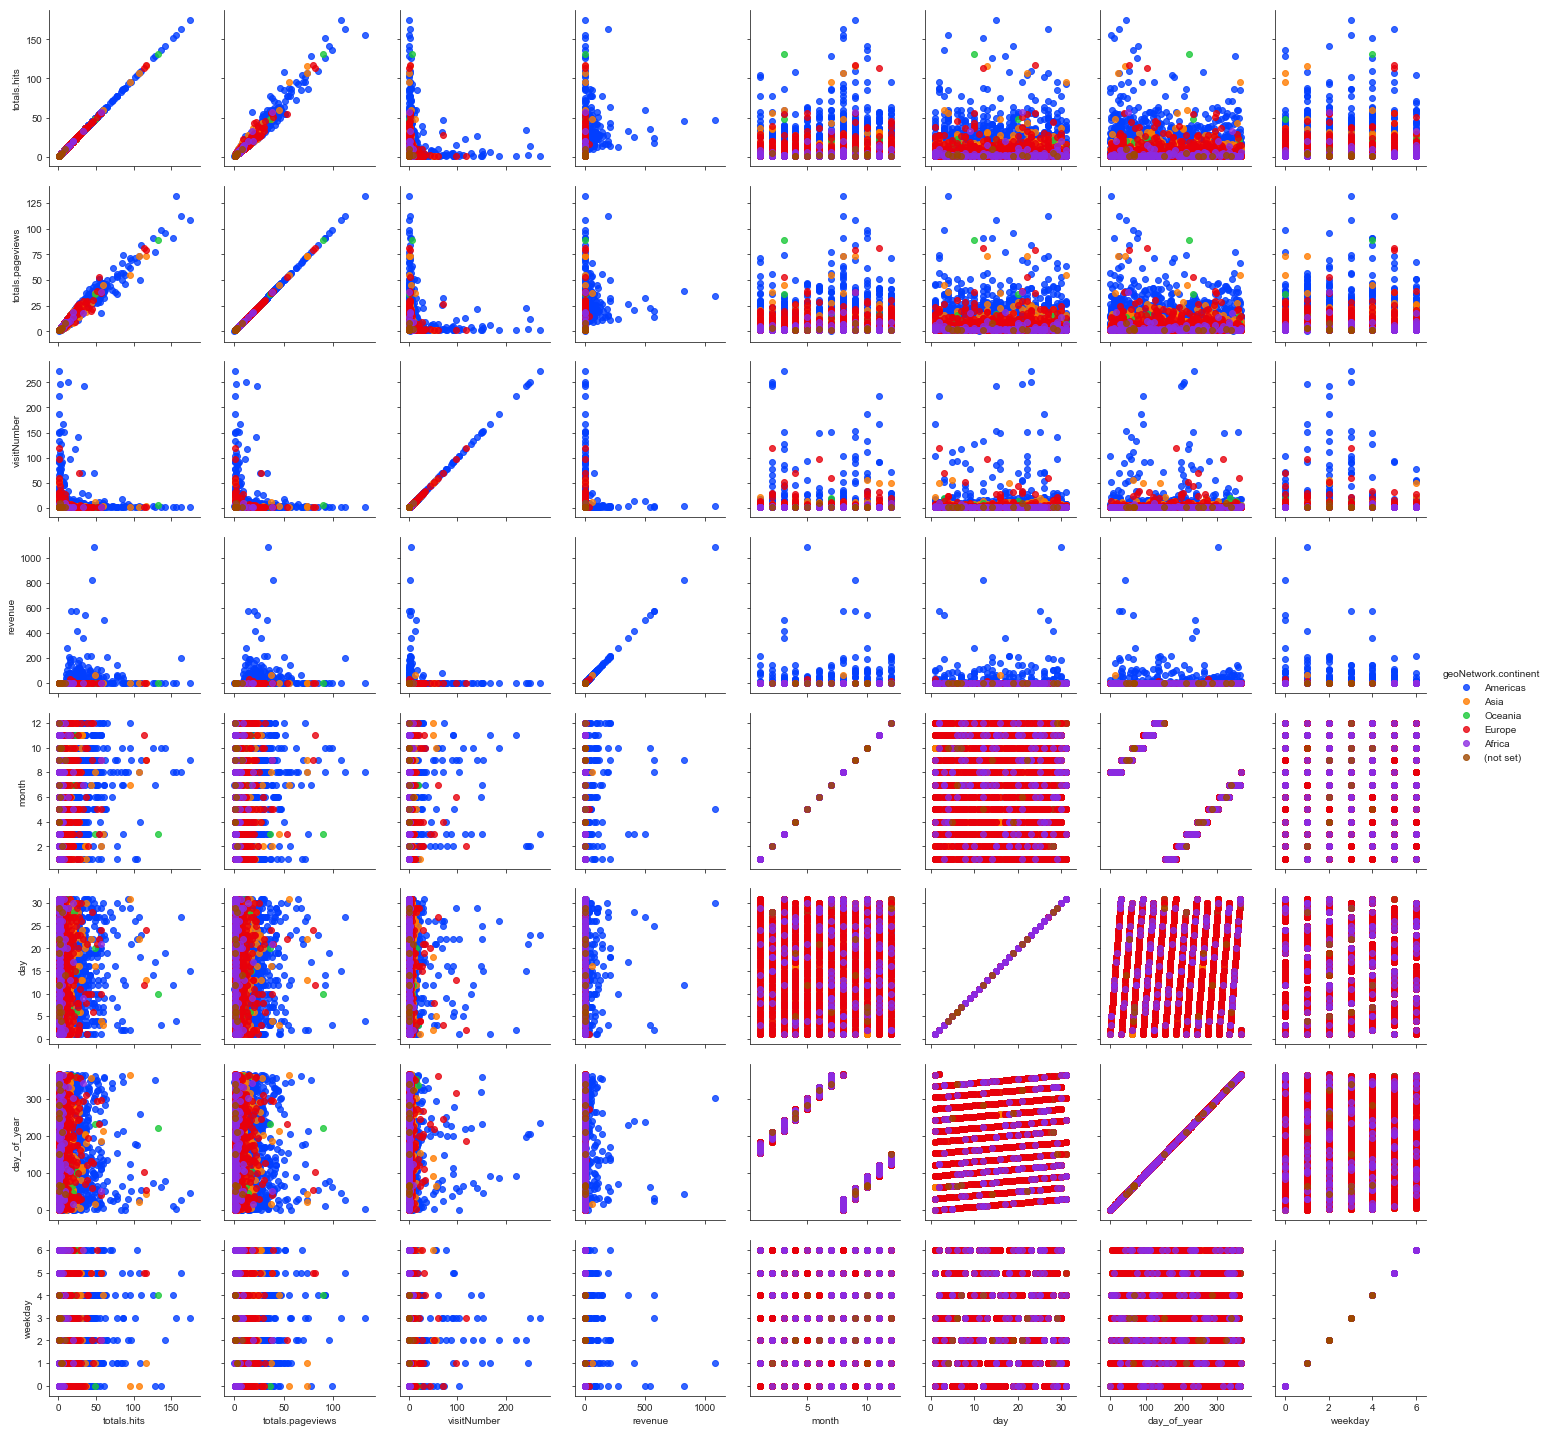

In [57]:
g = sns.PairGrid(sample, vars=['totals.hits', 'totals.pageviews','visitNumber',\
                               'revenue','month','day','day_of_year','weekday'],
                hue='geoNetwork.continent')
g.map(plt.scatter, alpha=0.8)
g.add_legend()

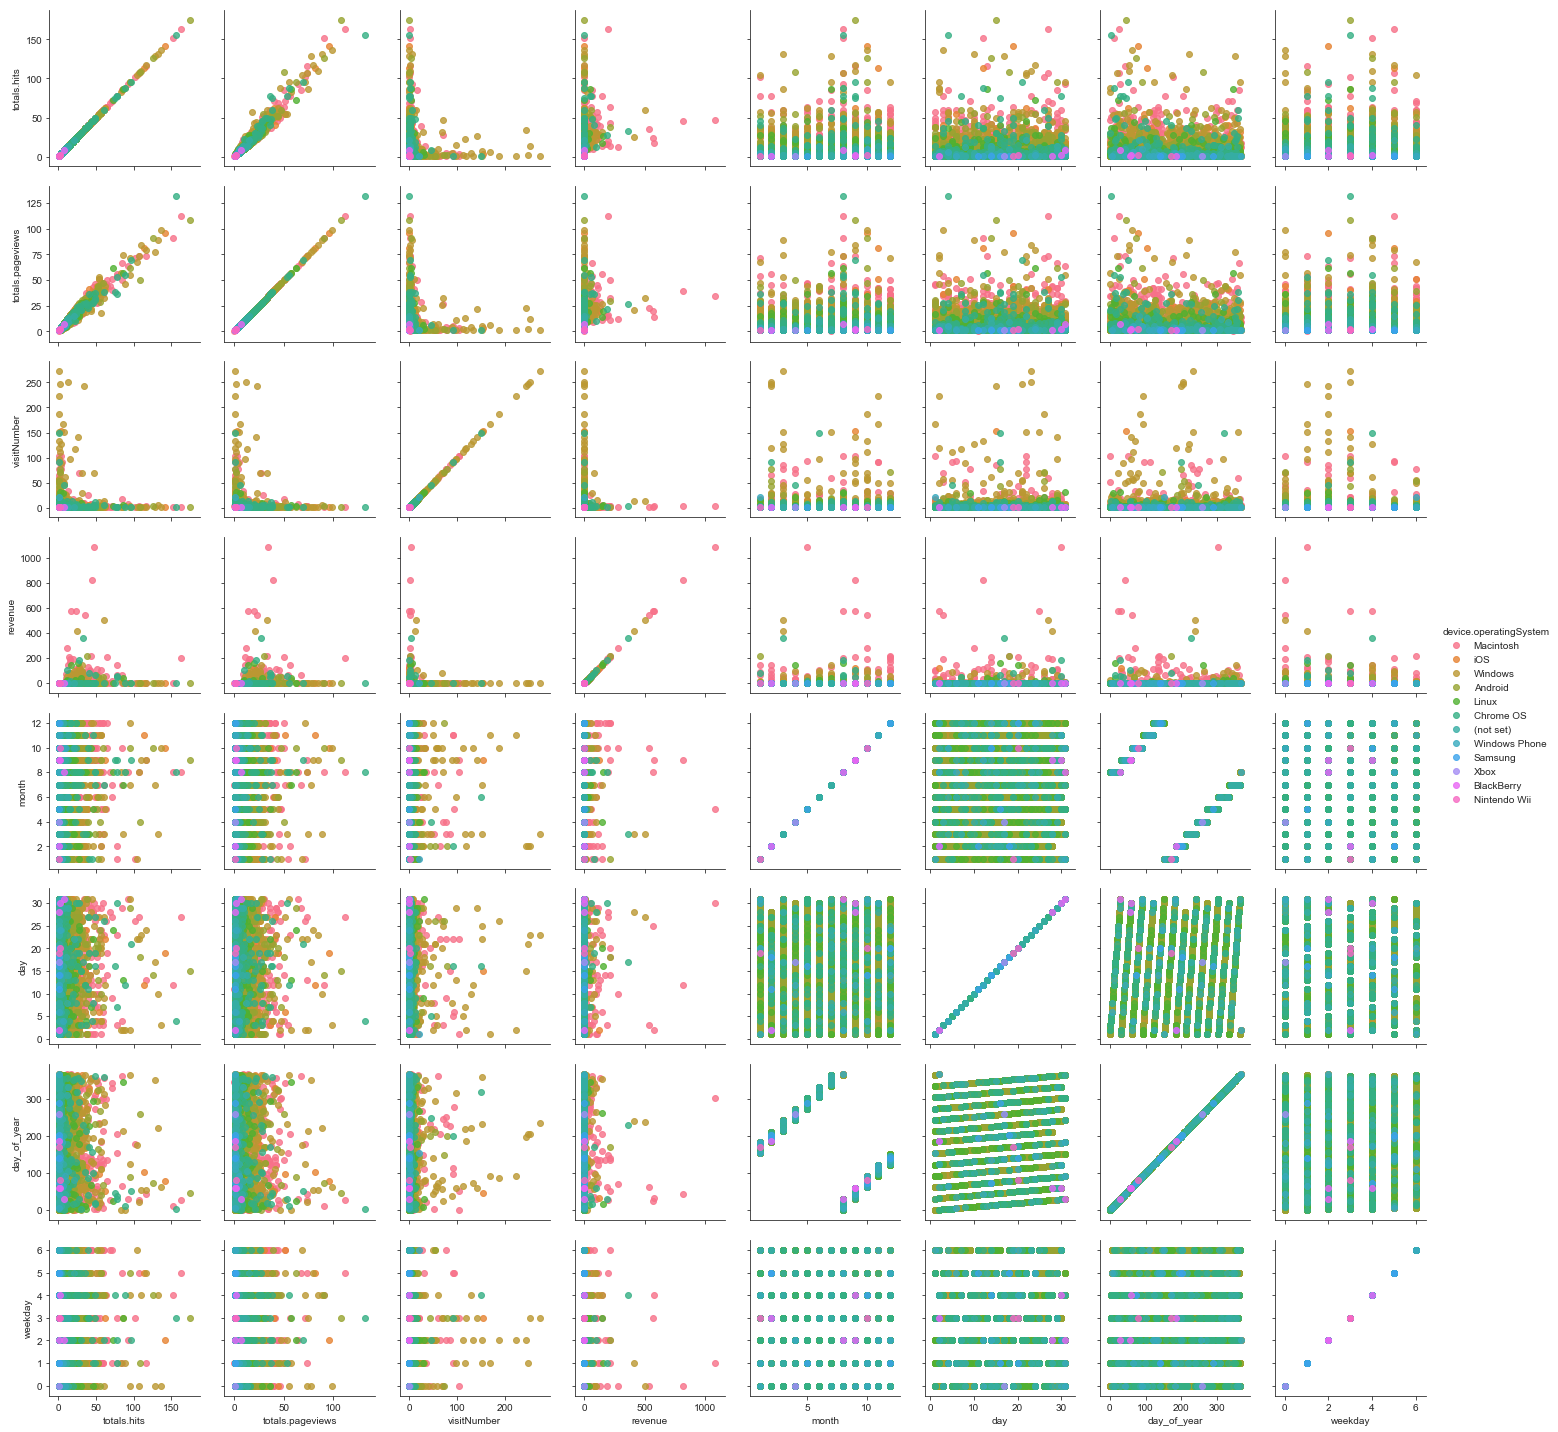

In [58]:
g = sns.PairGrid(sample, vars=['totals.hits', 'totals.pageviews','visitNumber',\
                               'revenue','month','day','day_of_year','weekday'],
                hue='device.operatingSystem')
g.map(plt.scatter, alpha=0.8)
g.add_legend()

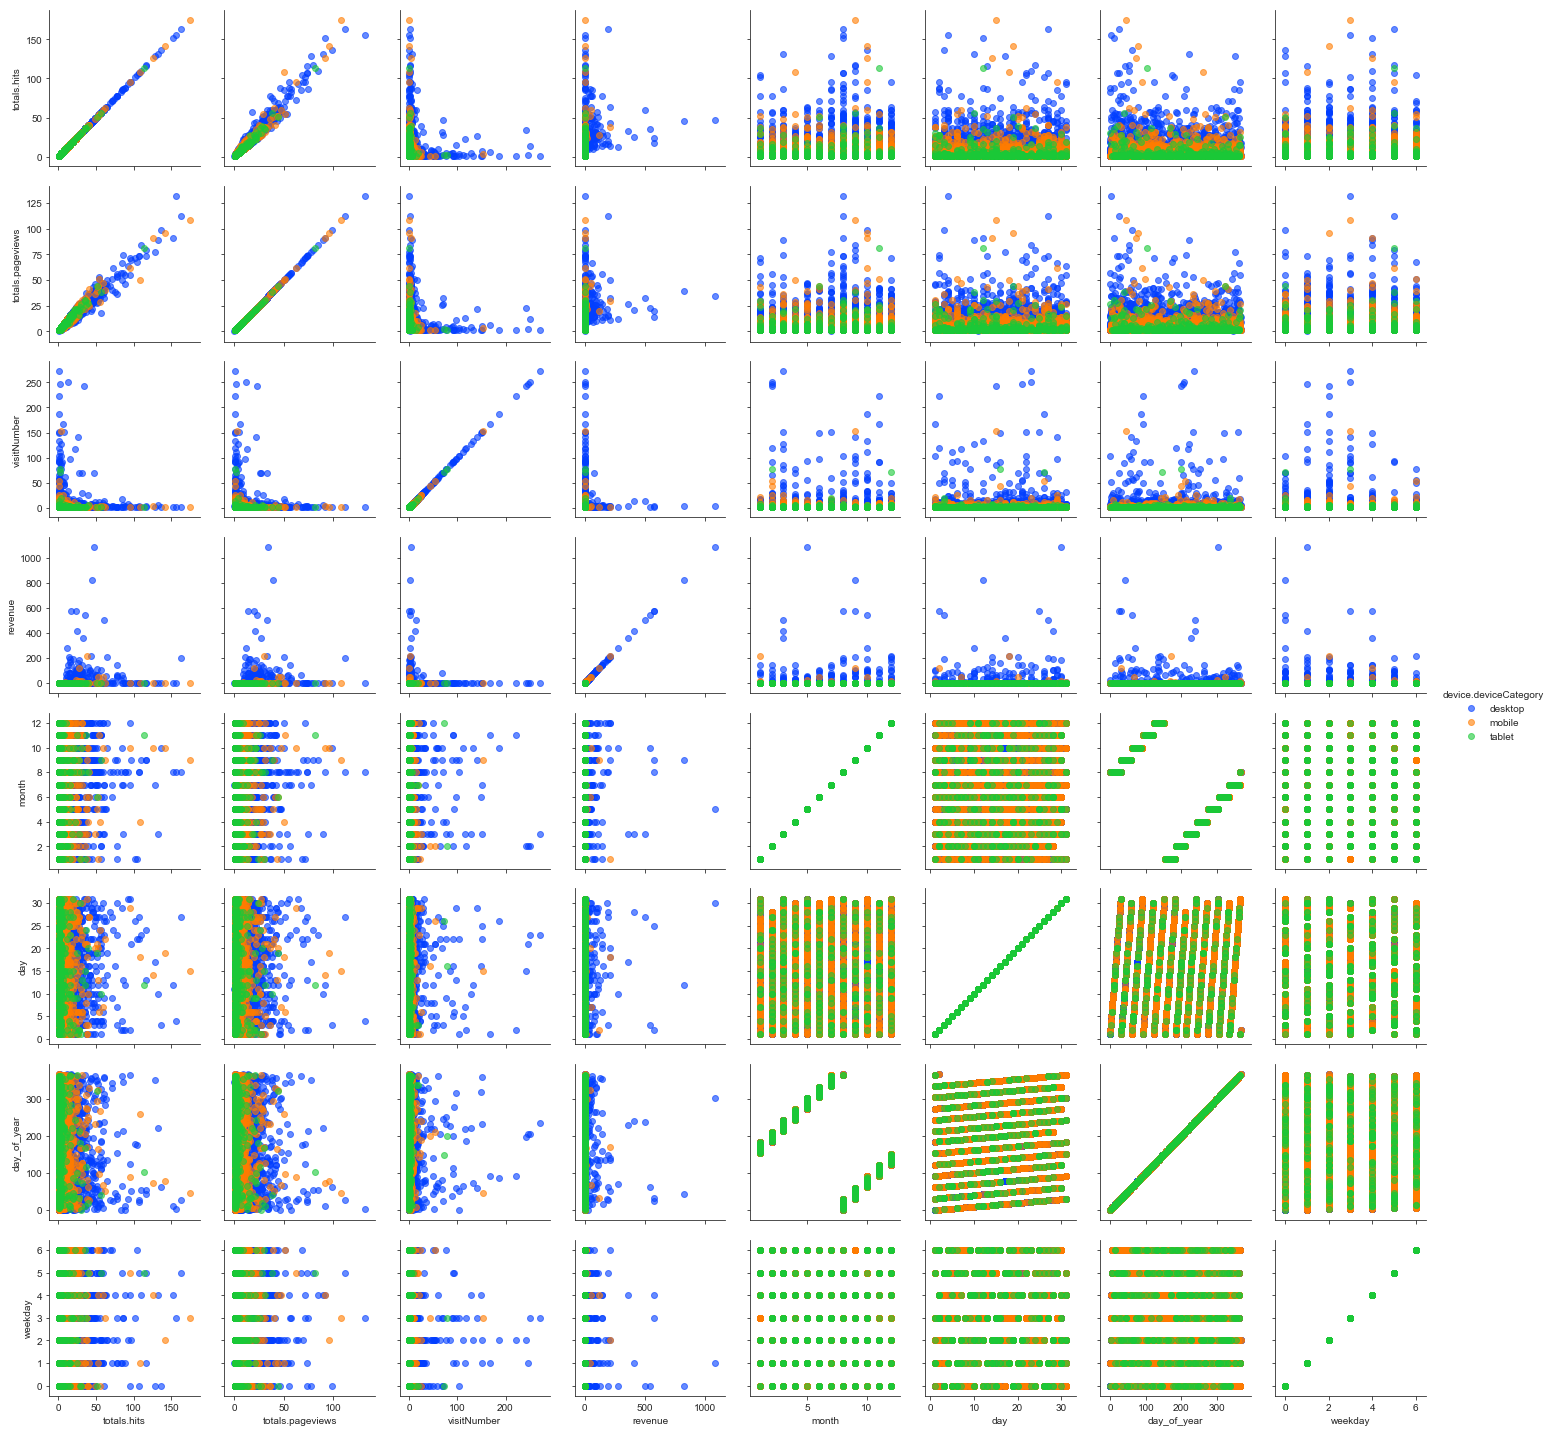

In [60]:
g = sns.PairGrid(sample, vars=['totals.hits', 'totals.pageviews','visitNumber',\
                               'revenue','month','day','day_of_year','weekday'],
                hue='device.deviceCategory')
g.map(plt.scatter, alpha=0.6)
g.add_legend()

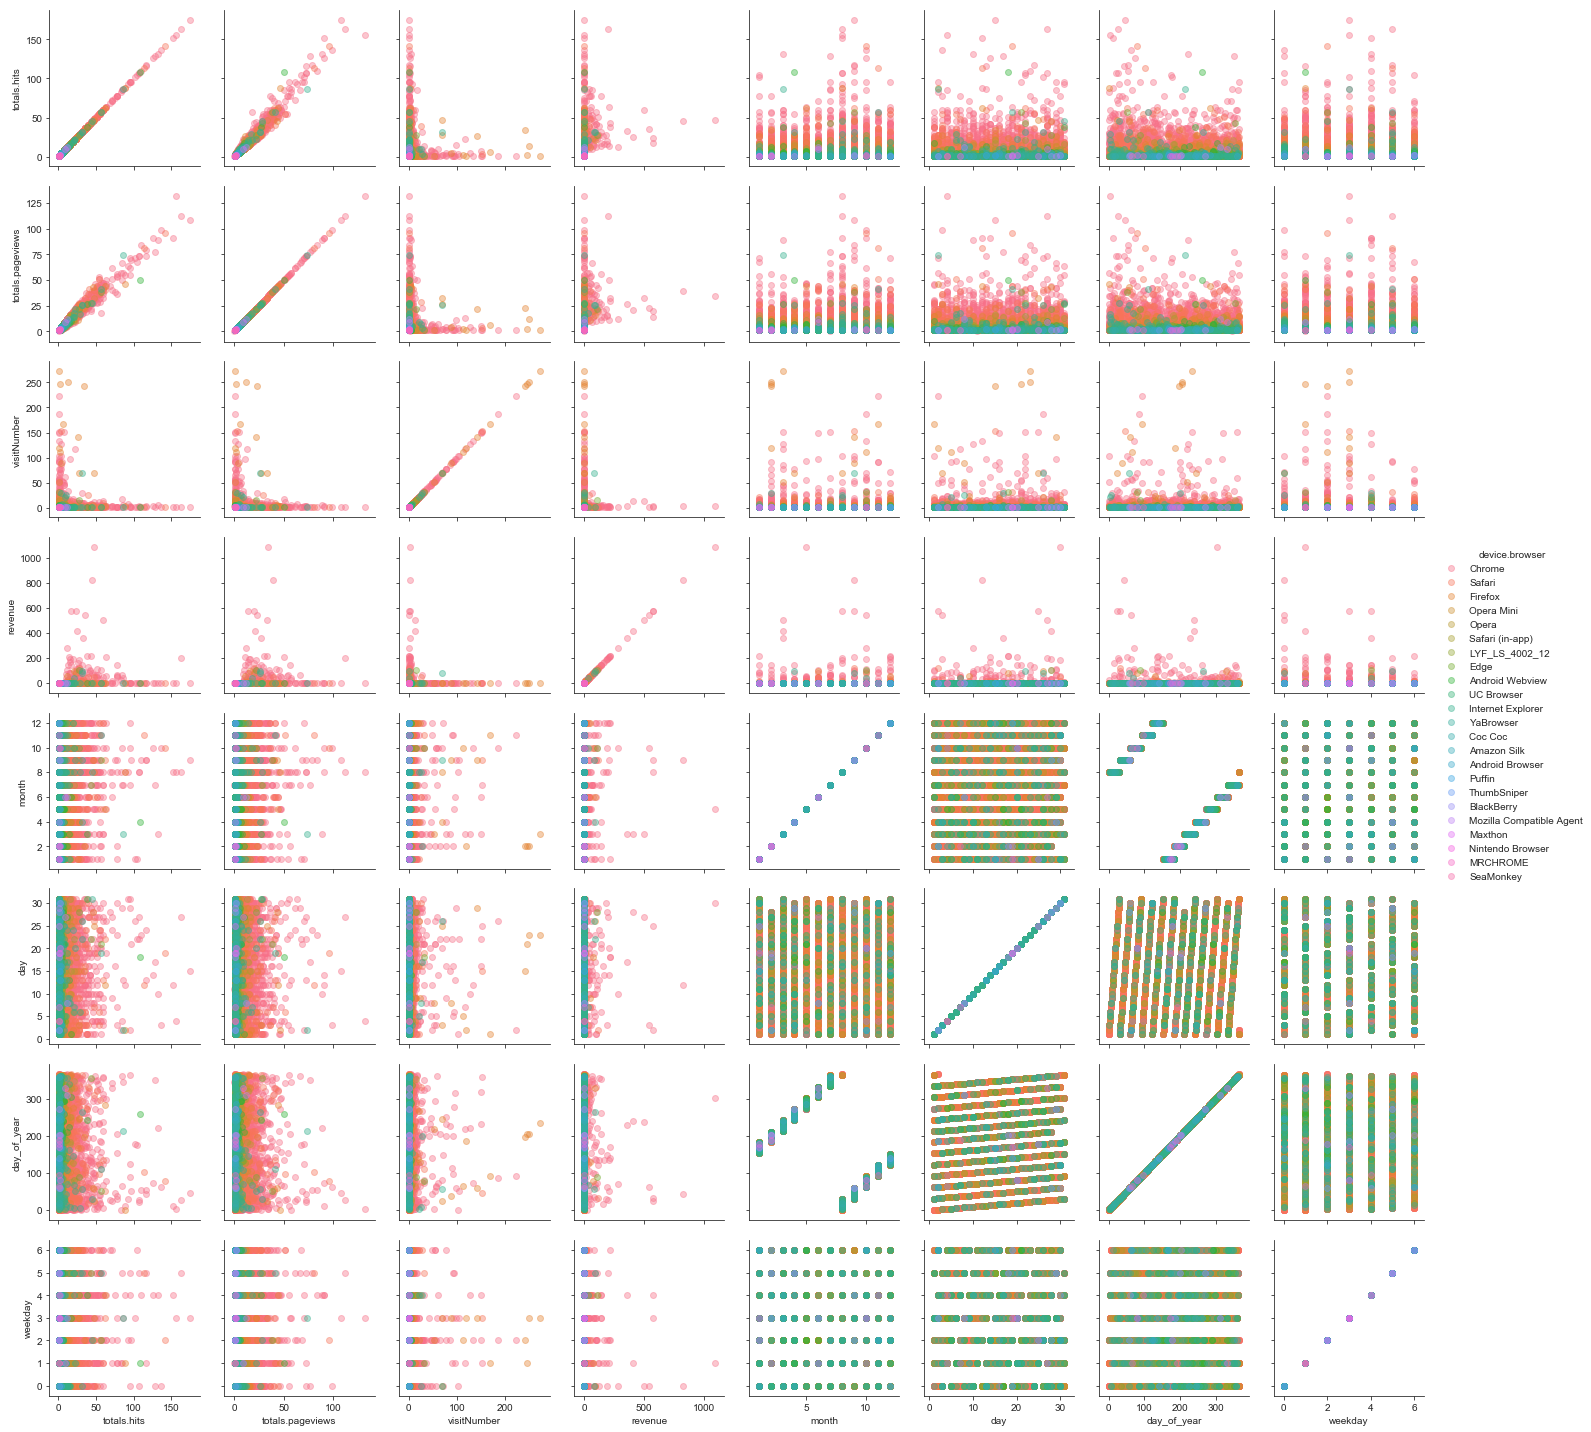

In [61]:
g = sns.PairGrid(sample, vars=['totals.hits', 'totals.pageviews','visitNumber',\
                               'revenue','month','day','day_of_year','weekday'],
                hue='device.browser')
g.map(plt.scatter, alpha=0.4)
g.add_legend()

### Hypothesis Testing

By looking at all these plots, one thing is clear that there is linear relationship between the hits and the page views. Logically also it makes sense. The more number of pages are browsed it will produce more hits/downloads. Now let us see if the correlation is statistically signficant. If the correlation is high we can try omitting one of the variable in our feature matrix to train the machine learning models. Such features produce multi-collinearity issues while model fitting. 

Formally, the correlation coefficient, r, tells us about the strength and direction of the linear relationship between x and y. However, the reliability of the linear model also depends on how many observed data points are in the sample. We need to look at both the value of the correlation coefficient r and the sample size n, together. The hypothesis test lets us decide whether the value of the population correlation coefficient 𝛒 is "close to zero" or "significantly different from zero". We decide this based on the sample correlation coefficient r and the sample size n.


**Null Hypothesis**: H0: 𝛒 = 0 

**Alternate Hypothesis**: Ha: 𝛒 ≠ 0

OR

**Null Hypothesis H0**: The population correlation coefficient IS NOT significantly different from zero. There IS NOT a significant linear relationship(correlation) between x and y in the population.

**Alternate Hypothesis Ha**: The population correlation coefficient IS significantly DIFFERENT FROM zero. There IS A SIGNIFICANT LINEAR RELATIONSHIP (correlation) between x and y in the population.

**at significance level (*α* = 0.01)**

We will accept or reject the Null hypothesis based on the p values. We will apply this to all the feature pairs and find the highest correlated features. And we can compare that with our previous results too.

In [11]:
train_df[['totals.hits','totals.pageviews']].describe()

,totals.hits,totals.pageviews
count,899888.000000,899888.000000
mean,4.595374,3.848378
std,9.634007,7.016116
min,1.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,4.000000,4.000000
max,500.000000,469.000000


In [67]:
# correlation coefficient between hits and pageviews
r,p = pearsonr(train_df['totals.hits'],train_df['totals.pageviews'])
r,p

array([[1.        , 0.98320238],
       [0.98320238, 1.        ]])

**Conclusion**

The above p value is zero and we reject the null hypothesis that the population correlation is zero. The variables hits and pageViews have very high statistically significant correlation of 0.98 at significance level of 1%.

### Fit linear regression line for hits and pageViews for different revenue bins

In [5]:
# function to get color from color palatte
def get_colors(num):
    cp=sns.color_palette(palette='bright')
    color=[cp[i] for i in np.random.randint(0,10,size=num)]
    return color

In [6]:
def get_rev_color(revenue, colrs):
    if revenue<200:
        return colrs[0]
    elif revenue<500:
        return colrs[1]
    elif revenue<1000:
        return colrs[2]
    elif revenue<10000:
        return colrs[3]
    else:
        return colrs[4]    

In [7]:
color_choices = get_colors(5)
color_choices

[(0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.7686274509803922, 0.0)]

In [8]:
train_df['rev_colors'] = [get_rev_color(rev, color_choices) for rev in train_df['revenue']]

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



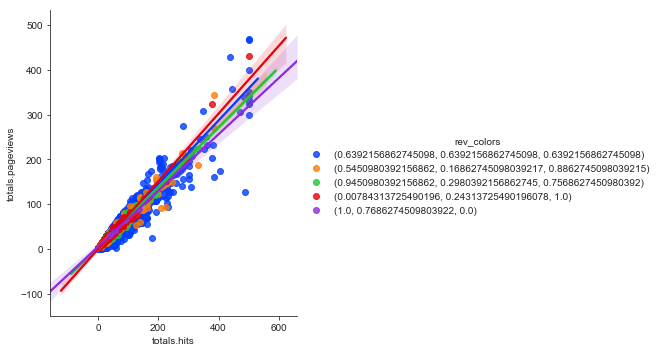

In [75]:
# let us study hits and pageviews closely
sns.lmplot(x='totals.hits',y='totals.pageviews', data=train_df, hue='rev_colors', fit_reg=True)

### Further thoughts for to try out 

After lots of exploratory data analysis there are many facts that become clearer. For e.g. if the visit time is around morning hours between 7AM to 12PM, there is less chance of revenue generation.

Based on the analysis the following conditions indicate higher revenue visits. We can hypothesize based on these and test their significances.

In [85]:
# good revenue if following combinations

condition1 = ((train_df['visitNumber'] < 30) | (train_df['visitNumber'] > 280))
condition2 = (train_df['channelGrouping'] == 'Display')
condition3 = (~train_df['month'].isin([10,11]))
condition4 = (~train_df['weekday'].isin([6,7]))
condition5 = (train_df['day_of_year'] > 330)
condition6 = (~train_df['local_hour'].isin([7,8,9,10,11,12]))
condition7 = (train_df['device.operatingSystem'].isin(['Chrome OS','Linux']))
condition8 = (train_df['totals.hits']>20) & (train_df['totals.hits']<30)

In [86]:
train_df[(condition1 & condition2 & condition3 & condition4 & condition6)]['revenue'].mean()

5.870997641509434

In [84]:
train_df[(condition4)]['revenue'].shape, train_df[(condition4)]['revenue'].mean()

((703997,), 1.9792396558507377)

In [79]:
train_df[condition8]['revenue'].mean()

12.904817799781238